In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('float_format', '{:f}'.format)

In [2]:
def get_cols(df: pd.DataFrame) -> tuple:
    numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
    categorical_columns = df.select_dtypes(exclude=np.number).columns.tolist()

    return numeric_columns, categorical_columns

# *balances*

In [ ]:
df_balances = (
    pd.read_csv('../data/raw/balances.csv')
    [['PERIODO','ID','CANT_EMP_NEG','CANT_EMP_CONS','CANT_EMP_HIPOT','SALDO_MED_EMP','SALDO_PEQ_EMP','SALDO_MIC_EMP','SALDO_CONS_REV','SALDO_CONS_NO_REV','SALDO_HIPOT','SALDO_VENCIDO']]
)

"""
PERIODO - Periodo de extracción de los datos
ID - Identificador único

CANT_EMP_NEG - Cantidad de empresas de negocio
CANT_EMP_CONS - Cantidad de empresas de consumo
CANT_EMP_HIPOT - Cantidad de empresas hipotecario
    * last
    * variable para ver si cerro o abrio empresas en los ultimos 9 meses

SALDO_MED_EMP - Saldo en mediana empresa
SALDO_PEQ_EMP - Saldo en pequeña empresa
SALDO_MIC_EMP - Saldo en micro empresa
    * categorica para saber que tipo de empresa tiene
    * last
    * variacion promedio de los saldos en los saldos que tiene

SALDO_CONS_REV - Saldo Consumo revolvente
SALDO_CONS_NO_REV - Saldo Consumo NO revolvente
    
SALDO_HIPOT - Saldo en hipotecario
SALDO_VENCIDO - Saldo vencido

CANT_EMP_DOL_NEG - Cantidad de empresas de negocios en dólares
SALDO_DOLA_NEG - Saldo en dólares de negocio
CANT_EMP_DOL_CONS - Cantidad de empresas de consumo en dólares
SALDO_DOLA_CONS - Saldo en dólares de consumo
CANT_EMP_DOL_HIPOT - Cantidad de empresas de hipotecario en dólares
SALDO_DOLA_HIPOT - Saldo en dólares de hipotecario
MAX_LINEA_DISP_U6M - Línea Máxima disponible en los últimos 6 meses
"""


In [ ]:
df_balances['SALDO_EMP_TOTAL'] = df_balances['SALDO_MED_EMP'] + df_balances['SALDO_PEQ_EMP'] + df_balances['SALDO_MIC_EMP'] + df_balances['SALDO_HIPOT']
df_balances['SALDO_EMP_TOTAL-VENCIDO'] = df_balances['SALDO_EMP_TOTAL'] - df_balances['SALDO_VENCIDO']
df_balances['SALDO_REV_NO_REV-VENCIDO'] = df_balances['SALDO_CONS_REV'] + df_balances['SALDO_CONS_NO_REV'] - df_balances['SALDO_VENCIDO']
df_balances['SALDO_TOTAL-VENCIDO'] = df_balances['SALDO_EMP_TOTAL'] + df_balances['SALDO_CONS_REV'] + df_balances['SALDO_CONS_NO_REV'] - df_balances['SALDO_VENCIDO']

df_balances['PROXY_MOROSIDAD_1'] = df_balances['SALDO_VENCIDO'] / df_balances['SALDO_EMP_TOTAL']
df_balances['PROXY_MOROSIDAD_2'] = df_balances['SALDO_VENCIDO'] / (df_balances['SALDO_EMP_TOTAL'] + df_balances['SALDO_CONS_REV'] + df_balances['SALDO_CONS_NO_REV'])
df_balances['PROXY_MOROSIDAD_3'] = df_balances['SALDO_VENCIDO'] / (df_balances['SALDO_CONS_REV'] + df_balances['SALDO_CONS_NO_REV'])

In [ ]:
df_balances.head(9*4)

In [ ]:
# 'SALDO_EMP_TOTAL', 'SALDO_PEQ_EMP', 'SALDO_MED_EMP', 'SALDO_MIC_EMP', 'SALDO_CONS_REV', 'SALDO_CONS_NO_REV', 'SALDO_HIPOT', 'SALDO_VENCIDO'

for col in ['SALDO_EMP_TOTAL', 'SALDO_EMP_TOTAL-VENCIDO', 'SALDO_REV_NO_REV-VENCIDO', 'SALDO_TOTAL-VENCIDO']:
    print(col)
    df_balances[f'VAR_{col}_1'] = df_balances.groupby('ID')[f'{col}'].transform(lambda x: x.pct_change(periods=1))
    df_balances[f'VAR_{col}_MA3'] = df_balances.groupby('ID')[f'{col}'].transform(lambda x: x.pct_change(periods=1).rolling(window=3).mean())
    df_balances[f'VAR_{col}_MA6'] = df_balances.groupby('ID')[f'{col}'].transform(lambda x: x.pct_change(periods=1).rolling(window=6).mean())
    df_balances[f'VAR_{col}_MA8'] = df_balances.groupby('ID')[f'{col}'].transform(lambda x: x.pct_change(periods=1).rolling(window=8).mean())
    
for col in ['SALDO_PEQ_EMP', 'SALDO_MED_EMP', 'SALDO_MIC_EMP'] + ['CANT_EMP_NEG', 'CANT_EMP_CONS', 'CANT_EMP_HIPOT']:
    print(col)
    df_balances[f'{col}_FLAG'] = df_balances[f'{col}'].apply(lambda x: True if x != 0 else False)

df_balances.head(9*4)

In [ ]:
df_balances.to_parquet('../data/processed/balances.gzip', compression='gzip')

In [ ]:

# df_balances['CANT_EMP_TOTAL'] = df_balances['CANT_EMP_NEG'] + df_balances['CANT_EMP_CONS'] + df_balances['CANT_EMP_HIPOT']    # ? las empresas son excluyentes?

In [ ]:
# df_balances.head(50)

In [ ]:
# list(df_balances['ID'].unique())

In [ ]:
df_balances.describe()

In [ ]:
df_balances.loc[df_balances['ID'] == '5da41258ad18492ea3aac6cc6c1e7a32']

In [ ]:
df_balances.dtypes

In [ ]:
df_balances.groupby('ID').agg({'PERIODO': 'unique'})

In [ ]:
plt.hist(df_balances['ID'].value_counts().reset_index()['count'])

In [ ]:
df_balances.isnull().sum() / len(df_balances)

In [ ]:
df_aux = df_balances.copy().replace(0, np.nan)
msno.matrix(df_aux, figsize=(10, 5))

In [3]:
df_balances = pd.read_parquet('../data/processed/balances.gzip')
df_balances.head(9*3)

,PERIODO,ID,CANT_EMP_NEG,CANT_EMP_CONS,CANT_EMP_HIPOT,SALDO_MED_EMP,SALDO_PEQ_EMP,SALDO_MIC_EMP,SALDO_CONS_REV,SALDO_CONS_NO_REV,SALDO_HIPOT,SALDO_VENCIDO,SALDO_EMP_TOTAL,SALDO_EMP_TOTAL-VENCIDO,SALDO_REV_NO_REV-VENCIDO,SALDO_TOTAL-VENCIDO,PROXY_MOROSIDAD_1,PROXY_MOROSIDAD_2,PROXY_MOROSIDAD_3,VAR_SALDO_EMP_TOTAL_1,VAR_SALDO_EMP_TOTAL_MA3,VAR_SALDO_EMP_TOTAL_MA6,VAR_SALDO_EMP_TOTAL_MA8,VAR_SALDO_EMP_TOTAL-VENCIDO_1,VAR_SALDO_EMP_TOTAL-VENCIDO_MA3,VAR_SALDO_EMP_TOTAL-VENCIDO_MA6,VAR_SALDO_EMP_TOTAL-VENCIDO_MA8,VAR_SALDO_REV_NO_REV-VENCIDO_1,VAR_SALDO_REV_NO_REV-VENCIDO_MA3,VAR_SALDO_REV_NO_REV-VENCIDO_MA6,VAR_SALDO_REV_NO_REV-VENCIDO_MA8,VAR_SALDO_TOTAL-VENCIDO_1,VAR_SALDO_TOTAL-VENCIDO_MA3,VAR_SALDO_TOTAL-VENCIDO_MA6,VAR_SALDO_TOTAL-VENCIDO_MA8,SALDO_PEQ_EMP_FLAG,SALDO_MED_EMP_FLAG,SALDO_MIC_EMP_FLAG,CANT_EMP_NEG_FLAG,CANT_EMP_CONS_FLAG,CANT_EMP_HIPOT_FLAG
0,202301,858130171a01415f93d40802fc9e192d,1,0,0,0.000000,0.000000,405.000000,0.000000,0.000000,0.000000,0.000000,405.000000,405.000000,0.000000,405.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,True,False,False
1,202302,858130171a01415f93d40802fc9e192d,1,0,0,0.000000,0.000000,346.566600,0.000000,0.000000,0.000000,0.000000,346.566600,346.566600,0.000000,346.566600,0.000000,0.000000,NaN,-0.144280,NaN,NaN,NaN,-0.144280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.144280,NaN,NaN,NaN,False,False,True,True,False,False
2,202303,858130171a01415f93d40802fc9e192d,1,0,0,0.000000,0.000000,283.086900,0.000000,0.000000,0.000000,0.000000,283.086900,283.086900,0.000000,283.086900,0.000000,0.000000,NaN,-0.183167,NaN,NaN,NaN,-0.183167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.183167,NaN,NaN,NaN,False,False,True,True,False,False
3,202304,858130171a01415f93d40802fc9e192d,1,0,0,0.000000,0.000000,217.987200,0.000000,0.000000,0.000000,0.000000,217.987200,217.987200,0.000000,217.987200,0.000000,0.000000,NaN,-0.229964,-0.185804,NaN,NaN,-0.229964,-0.185804,NaN,NaN,NaN,NaN,NaN,NaN,-0.229964,-0.185804,NaN,NaN,False,False,True,True,False,False
4,202305,858130171a01415f93d40802fc9e192d,1,0,0,0.000000,0.000000,148.942800,0.000000,0.000000,0.000000,0.000000,148.942800,148.942800,0.000000,148.942800,0.000000,0.000000,NaN,-0.316736,-0.243289,NaN,NaN,-0.316736,-0.243289,NaN,NaN,NaN,NaN,NaN,NaN,-0.316736,-0.243289,NaN,NaN,False,False,True,True,False,False
5,202306,858130171a01415f93d40802fc9e192d,1,0,0,0.000000,0.000000,76.512600,0.000000,0.000000,0.000000,0.000000,76.512600,76.512600,0.000000,76.512600,0.000000,0.000000,NaN,-0.486295,-0.344332,NaN,NaN,-0.486295,-0.344332,NaN,NaN,NaN,NaN,NaN,NaN,-0.486295,-0.344332,NaN,NaN,False,False,True,True,False,False
6,202307,858130171a01415f93d40802fc9e192d,1,1,0,0.000000,0.000000,1215.000000,0.000000,1826.041500,0.000000,0.000000,1215.000000,1215.000000,1826.041500,3041.041500,0.000000,0.000000,0.000000,14.879737,4.692235,2.253216,NaN,14.879737,4.692235,2.253216,NaN,inf,NaN,NaN,NaN,38.745630,12.647533,6.230865,NaN,False,False,True,True,True,False
7,202308,858130171a01415f93d40802fc9e192d,1,1,0,0.000000,0.000000,1038.573900,0.000000,1826.041500,0.000000,0.000000,1038.573900,1038.573900,1826.041500,2864.615400,0.000000,0.000000,0.000000,-0.145207,4.749412,2.253061,NaN,-0.145207,4.749412,2.253061,NaN,0.000000,NaN,NaN,NaN,-0.058015,12.733773,6.245242,NaN,False,False,True,True,True,False
8,202309,858130171a01415f93d40802fc9e192d,1,1,0,0.000000,0.000000,852.508800,0.000000,1620.550100,0.000000,0.000000,852.508800,852.508800,1620.550100,2473.058900,0.000000,0.000000,0.000000,-0.179154,4.851792,2.253730,1.649367,-0.179154,4.851792,2.253730,1.649367,-0.112534,NaN,NaN,NaN,-0.136687,12.850309,6.252989,4.648811,False,False,True,True,True,False
9,202301,26b25bfb3c114bf89e4112eb21b1c553,1,0,0,0.000000,0.000000,2459.897100,0.000000,0.000000,0.000000,0.000000,2459.897100,2459.897100,0.000000,2459.897100,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,True,False,False


In [4]:
df_balances.columns

Index(['PERIODO', 'ID', 'CANT_EMP_NEG', 'CANT_EMP_CONS', 'CANT_EMP_HIPOT',
       'SALDO_MED_EMP', 'SALDO_PEQ_EMP', 'SALDO_MIC_EMP', 'SALDO_CONS_REV',
       'SALDO_CONS_NO_REV', 'SALDO_HIPOT', 'SALDO_VENCIDO', 'SALDO_EMP_TOTAL',
       'SALDO_EMP_TOTAL-VENCIDO', 'SALDO_REV_NO_REV-VENCIDO',
       'SALDO_TOTAL-VENCIDO', 'PROXY_MOROSIDAD_1', 'PROXY_MOROSIDAD_2',
       'PROXY_MOROSIDAD_3', 'VAR_SALDO_EMP_TOTAL_1', 'VAR_SALDO_EMP_TOTAL_MA3',
       'VAR_SALDO_EMP_TOTAL_MA6', 'VAR_SALDO_EMP_TOTAL_MA8',
       'VAR_SALDO_EMP_TOTAL-VENCIDO_1', 'VAR_SALDO_EMP_TOTAL-VENCIDO_MA3',
       'VAR_SALDO_EMP_TOTAL-VENCIDO_MA6', 'VAR_SALDO_EMP_TOTAL-VENCIDO_MA8',
       'VAR_SALDO_REV_NO_REV-VENCIDO_1', 'VAR_SALDO_REV_NO_REV-VENCIDO_MA3',
       'VAR_SALDO_REV_NO_REV-VENCIDO_MA6', 'VAR_SALDO_REV_NO_REV-VENCIDO_MA8',
       'VAR_SALDO_TOTAL-VENCIDO_1', 'VAR_SALDO_TOTAL-VENCIDO_MA3',
       'VAR_SALDO_TOTAL-VENCIDO_MA6', 'VAR_SALDO_TOTAL-VENCIDO_MA8',
       'SALDO_PEQ_EMP_FLAG', 'SALDO_MED_EMP_FLAG', 

In [5]:
df_balances_unirow = df_balances.groupby('ID').agg(
    {
        'CANT_EMP_NEG': ['max', 'last'],
        'CANT_EMP_CONS': ['max', 'last'],
        'CANT_EMP_HIPOT': ['max', 'last'],
        
        # 'SALDO_MED_EMP': ['mean', 'last', 'max', 'min'],
        # 'SALDO_PEQ_EMP': ['mean', 'last', 'max', 'min'],
        # 'SALDO_MIC_EMP': ['mean', 'last', 'max', 'min'],
        # 'SALDO_CONS_REV': ['mean', 'last', 'max', 'min'],
        # 'SALDO_CONS_NO_REV': ['mean', 'last', 'max', 'min'],
        # 'SALDO_HIPOT': ['mean', 'last', 'max', 'min'],
        # 'SALDO_VENCIDO': ['mean', 'last', 'max', 'min'],
        
        'VAR_SALDO_EMP_TOTAL_1' : ['mean', 'median'], 
        'VAR_SALDO_EMP_TOTAL_MA3' : ['mean', 'median'], 
        'VAR_SALDO_EMP_TOTAL_MA6' : ['mean', 'median'], 
        'VAR_SALDO_EMP_TOTAL_MA8' : ['mean', 'median'], 
        'VAR_SALDO_EMP_TOTAL-VENCIDO_1' : ['mean', 'median'],
        'VAR_SALDO_EMP_TOTAL-VENCIDO_MA3' : ['mean', 'median'],
        'VAR_SALDO_EMP_TOTAL-VENCIDO_MA6' : ['mean', 'median'],
        'VAR_SALDO_EMP_TOTAL-VENCIDO_MA8' : ['mean', 'median'],
        'VAR_SALDO_REV_NO_REV-VENCIDO_1' : ['mean', 'median'],
        'VAR_SALDO_REV_NO_REV-VENCIDO_MA3' : ['mean', 'median'],
        'VAR_SALDO_REV_NO_REV-VENCIDO_MA6' : ['mean', 'median'],
        'VAR_SALDO_REV_NO_REV-VENCIDO_MA8' : ['mean', 'median'],
        'VAR_SALDO_TOTAL-VENCIDO_1' : ['mean', 'median'],
        'VAR_SALDO_TOTAL-VENCIDO_MA3' : ['mean', 'median'],
        'VAR_SALDO_TOTAL-VENCIDO_MA6' : ['mean', 'median'],
        'VAR_SALDO_TOTAL-VENCIDO_MA8' : ['mean', 'median'],

        # 'SALDO_PEQ_EMP_FLAG' : ['any'],
        # 'SALDO_MED_EMP_FLAG' : ['any'],
        # 'SALDO_MIC_EMP_FLAG' : ['any'],
        # 'CANT_EMP_NEG_FLAG' : ['any'],
        # 'CANT_EMP_CONS_FLAG' : ['any'],
        # 'CANT_EMP_HIPOT_FLAG' : ['any'],

        'PROXY_MOROSIDAD_1': ['mean', 'max', 'min', 'median'],
        'PROXY_MOROSIDAD_2': ['mean', 'max', 'min', 'median'],
        'PROXY_MOROSIDAD_3': ['mean', 'max', 'min', 'median'],
    }
).replace([np.inf, -np.inf], np.nan).fillna(0)

df_balances_unirow.columns = ['_'.join(col) for col in df_balances_unirow.columns.values]
df_balances_unirow = df_balances_unirow.reset_index()

df_balances_unirow

,ID,CANT_EMP_NEG_max,CANT_EMP_NEG_last,CANT_EMP_CONS_max,CANT_EMP_CONS_last,CANT_EMP_HIPOT_max,CANT_EMP_HIPOT_last,VAR_SALDO_EMP_TOTAL_1_mean,VAR_SALDO_EMP_TOTAL_1_median,VAR_SALDO_EMP_TOTAL_MA3_mean,VAR_SALDO_EMP_TOTAL_MA3_median,VAR_SALDO_EMP_TOTAL_MA6_mean,VAR_SALDO_EMP_TOTAL_MA6_median,VAR_SALDO_EMP_TOTAL_MA8_mean,VAR_SALDO_EMP_TOTAL_MA8_median,VAR_SALDO_EMP_TOTAL-VENCIDO_1_mean,VAR_SALDO_EMP_TOTAL-VENCIDO_1_median,VAR_SALDO_EMP_TOTAL-VENCIDO_MA3_mean,VAR_SALDO_EMP_TOTAL-VENCIDO_MA3_median,VAR_SALDO_EMP_TOTAL-VENCIDO_MA6_mean,VAR_SALDO_EMP_TOTAL-VENCIDO_MA6_median,VAR_SALDO_EMP_TOTAL-VENCIDO_MA8_mean,VAR_SALDO_EMP_TOTAL-VENCIDO_MA8_median,VAR_SALDO_REV_NO_REV-VENCIDO_1_mean,VAR_SALDO_REV_NO_REV-VENCIDO_1_median,VAR_SALDO_REV_NO_REV-VENCIDO_MA3_mean,VAR_SALDO_REV_NO_REV-VENCIDO_MA3_median,VAR_SALDO_REV_NO_REV-VENCIDO_MA6_mean,VAR_SALDO_REV_NO_REV-VENCIDO_MA6_median,VAR_SALDO_REV_NO_REV-VENCIDO_MA8_mean,VAR_SALDO_REV_NO_REV-VENCIDO_MA8_median,VAR_SALDO_TOTAL-VENCIDO_1_mean,VAR_SALDO_TOTAL-VENCIDO_1_median,VAR_SALDO_TOTAL-VENCIDO_MA3_mean,VAR_SALDO_TOTAL-VENCIDO_MA3_median,VAR_SALDO_TOTAL-VENCIDO_MA6_mean,VAR_SALDO_TOTAL-VENCIDO_MA6_median,VAR_SALDO_TOTAL-VENCIDO_MA8_mean,VAR_SALDO_TOTAL-VENCIDO_MA8_median,PROXY_MOROSIDAD_1_mean,PROXY_MOROSIDAD_1_max,PROXY_MOROSIDAD_1_min,PROXY_MOROSIDAD_1_median,PROXY_MOROSIDAD_2_mean,PROXY_MOROSIDAD_2_max,PROXY_MOROSIDAD_2_min,PROXY_MOROSIDAD_2_median,PROXY_MOROSIDAD_3_mean,PROXY_MOROSIDAD_3_max,PROXY_MOROSIDAD_3_min,PROXY_MOROSIDAD_3_median
0,00000ae64b2d4ea7b318f3caa49fb832,1,1,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.026925,-0.029499,-0.025652,-0.025297,-0.025652,-0.025651,-0.026925,-0.026925,-0.026925,-0.029499,-0.025652,-0.025297,-0.025652,-0.025651,-0.026925,-0.026925,-0.026925,-0.029499,-0.025652,-0.025297,-0.025652,-0.025651,-0.026925,-0.026925,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,00002e673be949b1afe485e71ff71048,1,1,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0000e7adc30c476ba07265c60676562c,2,2,2,2,0,0,0.470330,-0.118679,0.663003,0.676836,0.663003,0.659017,0.470330,0.470330,0.470330,-0.118679,0.663003,0.676836,0.663003,0.659017,0.470330,0.470330,-0.071124,-0.068703,-0.070293,-0.068900,-0.070293,-0.070048,-0.071124,-0.071124,0.094030,-0.093146,0.153685,0.157084,0.153685,0.152708,0.094030,0.094030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,00014b0427554bbbad91e0d8aeab3118,2,2,0,0,0,0,0.066932,-0.116714,0.085015,0.102654,0.085015,0.102654,0.066932,0.066932,0.066932,-0.116714,0.085015,0.102654,0.085015,0.102654,0.066932,0.066932,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066932,-0.116714,0.085015,0.102654,0.085015,0.102654,0.066932,0.066932,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0001efa922ff405384514b5c6ed18294,1,0,1,1,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.051949,-0.067156,-0.051506,-0.051281,-0.051506,-0.053455,-0.051949,-0.051949,-0.051949,-0.067156,-0.051506,-0.051281,-0.051506,-0.053455,-0.051949,-0.051949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151967,fffe81ac4d864

{'whiskers': [<matplotlib.lines.Line2D at 0x7f09fe48e500>,
 'caps': [<matplotlib.lines.Line2D at 0x7f09fe48ea40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f09fe48e260>],
 'medians': [<matplotlib.lines.Line2D at 0x7f09fe48ef80>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f09fe48f220>],
 'means': []}

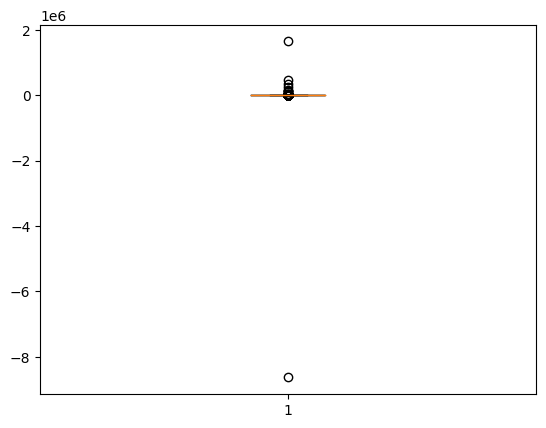

In [6]:
plt.boxplot(df_balances_unirow['VAR_SALDO_TOTAL-VENCIDO_MA6_median'])

In [7]:
nc, cc = get_cols(df_balances_unirow)
df_balances_unirow[nc].std(numeric_only=True).reset_index().sort_values(by=0, ascending=False)

,index,0
35,VAR_SALDO_TOTAL-VENCIDO_MA6_median,22617.757631
34,VAR_SALDO_TOTAL-VENCIDO_MA6_mean,22612.138969
18,VAR_SALDO_EMP_TOTAL-VENCIDO_MA6_mean,22233.764552
19,VAR_SALDO_EMP_TOTAL-VENCIDO_MA6_median,22233.047553
11,VAR_SALDO_EMP_TOTAL_MA6_median,22216.477058
10,VAR_SALDO_EMP_TOTAL_MA6_mean,22216.476996
32,VAR_SALDO_TOTAL-VENCIDO_MA3_mean,18322.146769
16,VAR_SALDO_EMP_TOTAL-VENCIDO_MA3_mean,17761.741784
8,VAR_SALDO_EMP_TOTAL_MA3_mean,17755.590122
33,VAR_SALDO_TOTAL-VENCIDO_MA3_median,4811.225288


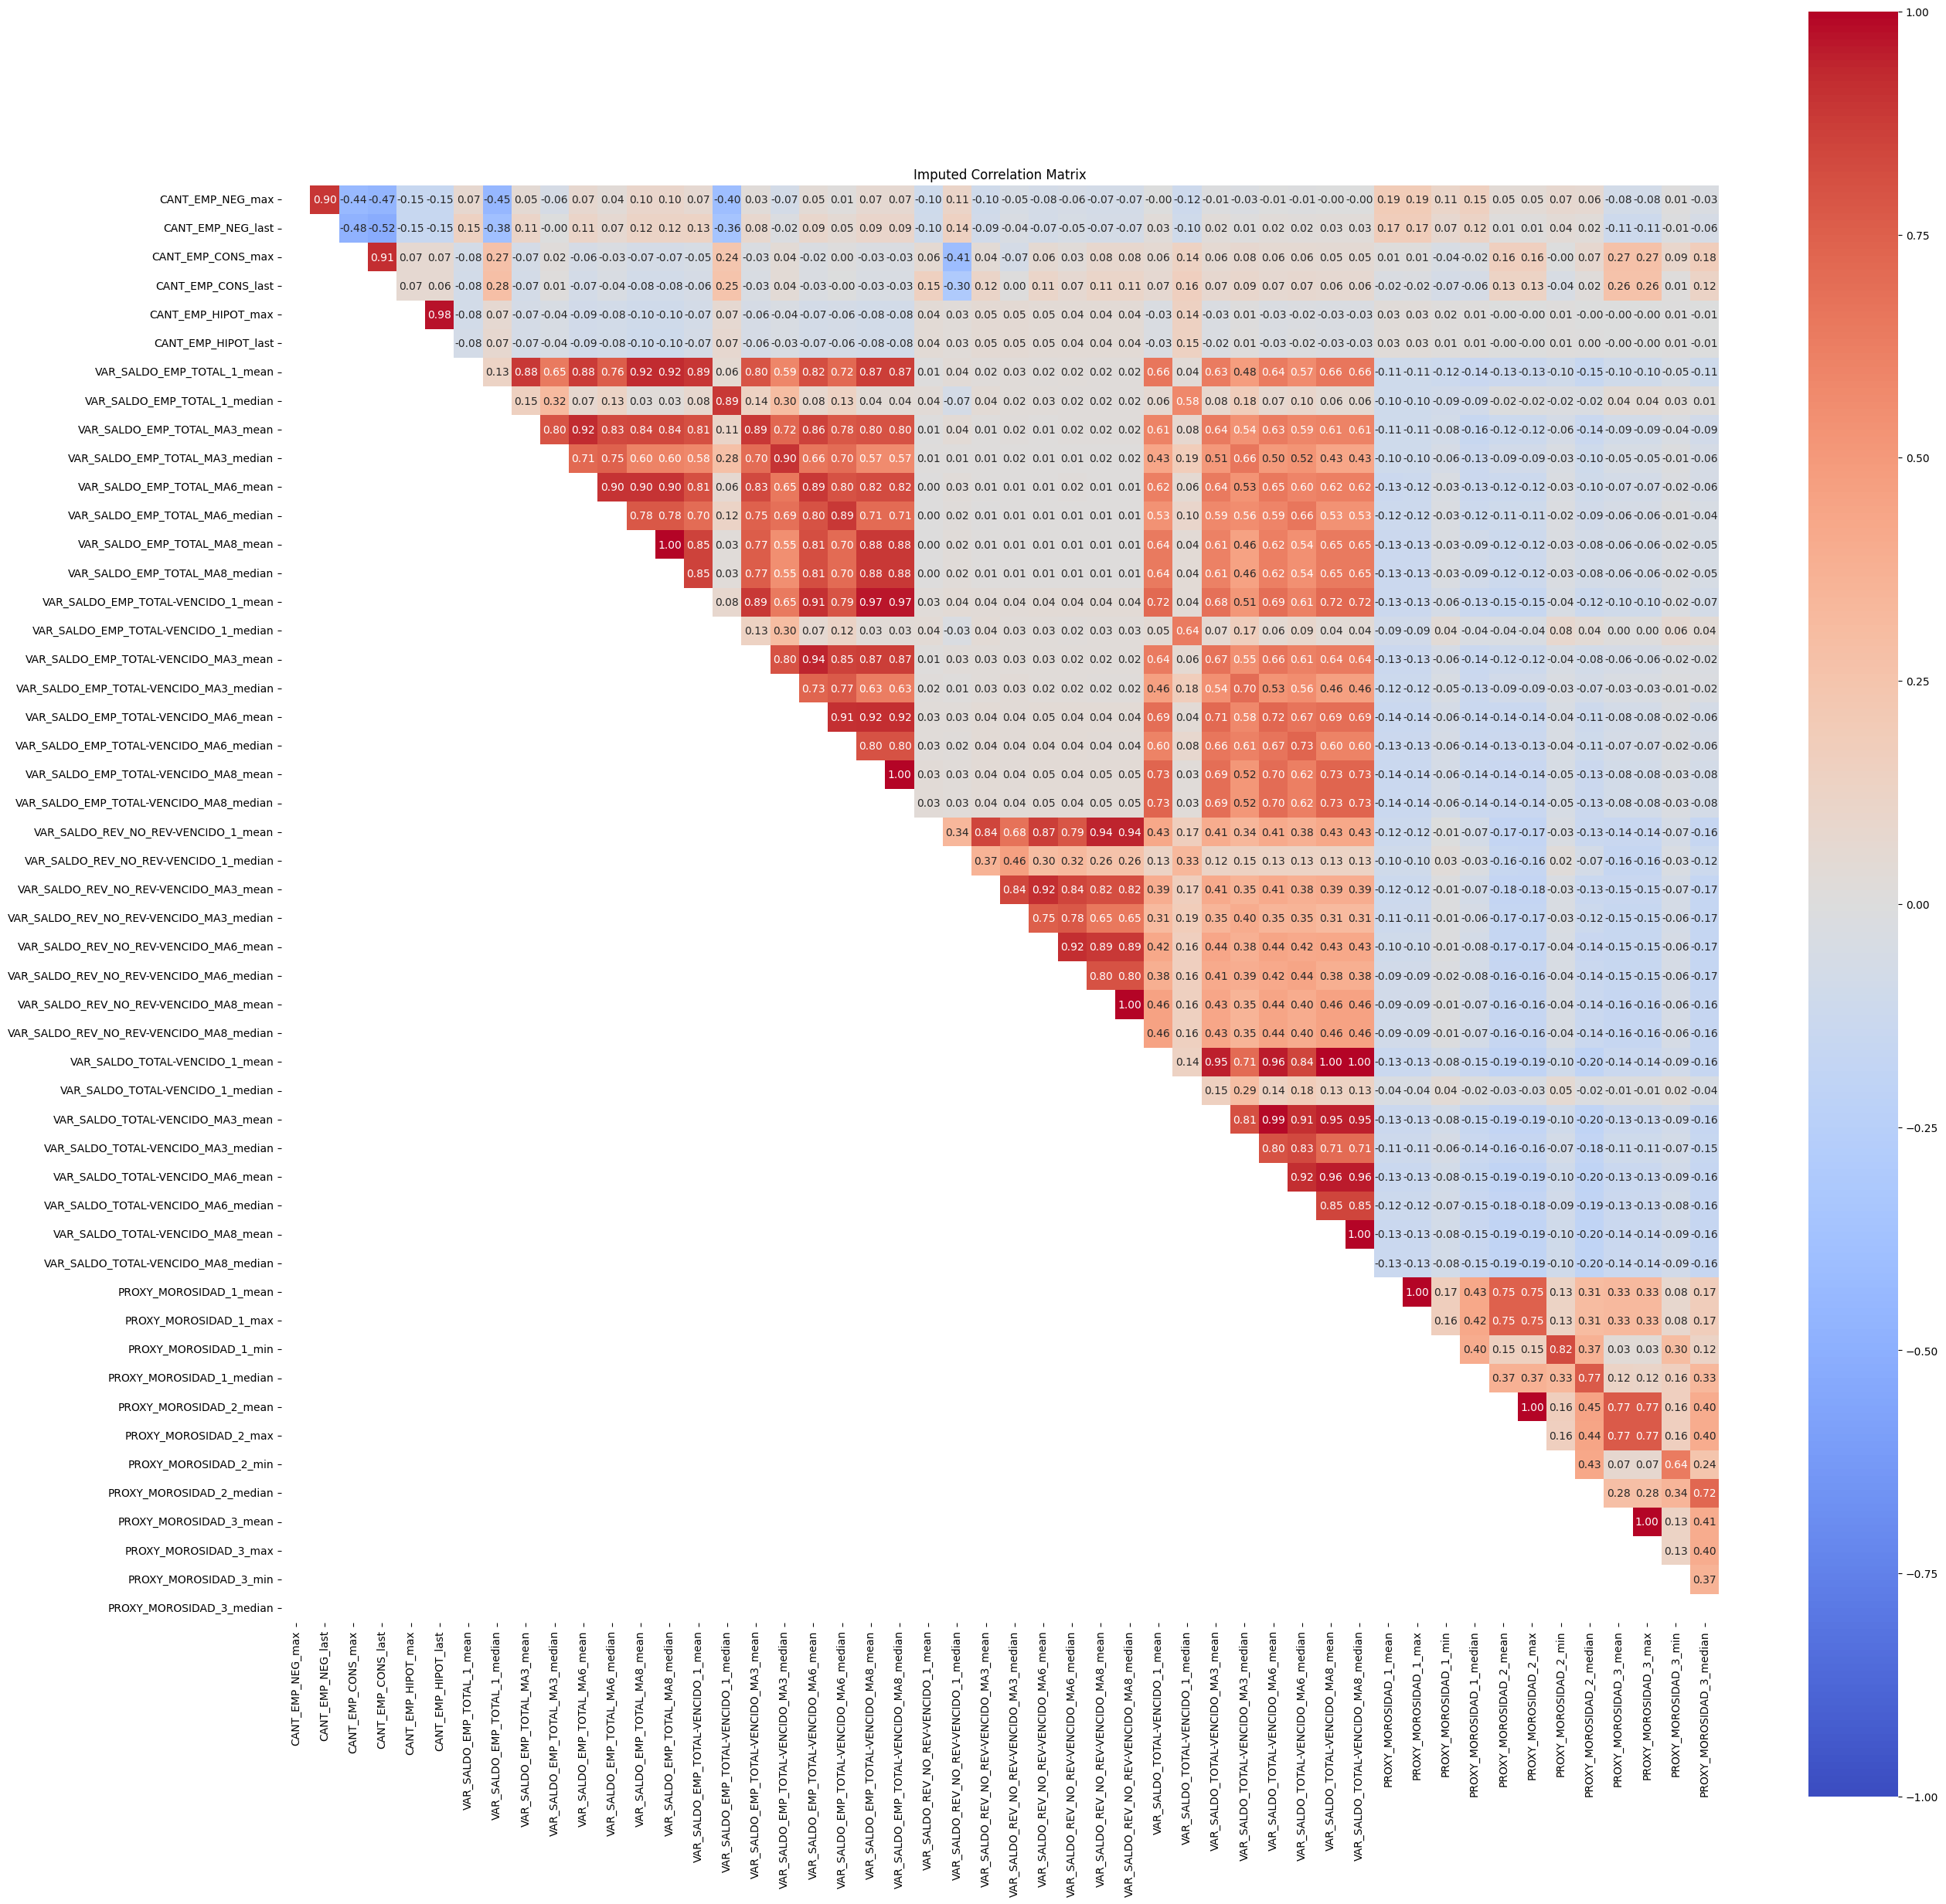

In [8]:
import numpy as np

corr_mat = df_balances_unirow[nc].corr(method='spearman')
mask = np.tril(np.ones_like(corr_mat, dtype=bool))  # create a mask to hide the lower triangle of the heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, fmt='.2f', mask=mask)  # add the mask to the heatmap
plt.title('Imputed Correlation Matrix')
plt.show()

In [9]:
df_balances_unirow

,ID,CANT_EMP_NEG_max,CANT_EMP_NEG_last,CANT_EMP_CONS_max,CANT_EMP_CONS_last,CANT_EMP_HIPOT_max,CANT_EMP_HIPOT_last,VAR_SALDO_EMP_TOTAL_1_mean,VAR_SALDO_EMP_TOTAL_1_median,VAR_SALDO_EMP_TOTAL_MA3_mean,VAR_SALDO_EMP_TOTAL_MA3_median,VAR_SALDO_EMP_TOTAL_MA6_mean,VAR_SALDO_EMP_TOTAL_MA6_median,VAR_SALDO_EMP_TOTAL_MA8_mean,VAR_SALDO_EMP_TOTAL_MA8_median,VAR_SALDO_EMP_TOTAL-VENCIDO_1_mean,VAR_SALDO_EMP_TOTAL-VENCIDO_1_median,VAR_SALDO_EMP_TOTAL-VENCIDO_MA3_mean,VAR_SALDO_EMP_TOTAL-VENCIDO_MA3_median,VAR_SALDO_EMP_TOTAL-VENCIDO_MA6_mean,VAR_SALDO_EMP_TOTAL-VENCIDO_MA6_median,VAR_SALDO_EMP_TOTAL-VENCIDO_MA8_mean,VAR_SALDO_EMP_TOTAL-VENCIDO_MA8_median,VAR_SALDO_REV_NO_REV-VENCIDO_1_mean,VAR_SALDO_REV_NO_REV-VENCIDO_1_median,VAR_SALDO_REV_NO_REV-VENCIDO_MA3_mean,VAR_SALDO_REV_NO_REV-VENCIDO_MA3_median,VAR_SALDO_REV_NO_REV-VENCIDO_MA6_mean,VAR_SALDO_REV_NO_REV-VENCIDO_MA6_median,VAR_SALDO_REV_NO_REV-VENCIDO_MA8_mean,VAR_SALDO_REV_NO_REV-VENCIDO_MA8_median,VAR_SALDO_TOTAL-VENCIDO_1_mean,VAR_SALDO_TOTAL-VENCIDO_1_median,VAR_SALDO_TOTAL-VENCIDO_MA3_mean,VAR_SALDO_TOTAL-VENCIDO_MA3_median,VAR_SALDO_TOTAL-VENCIDO_MA6_mean,VAR_SALDO_TOTAL-VENCIDO_MA6_median,VAR_SALDO_TOTAL-VENCIDO_MA8_mean,VAR_SALDO_TOTAL-VENCIDO_MA8_median,PROXY_MOROSIDAD_1_mean,PROXY_MOROSIDAD_1_max,PROXY_MOROSIDAD_1_min,PROXY_MOROSIDAD_1_median,PROXY_MOROSIDAD_2_mean,PROXY_MOROSIDAD_2_max,PROXY_MOROSIDAD_2_min,PROXY_MOROSIDAD_2_median,PROXY_MOROSIDAD_3_mean,PROXY_MOROSIDAD_3_max,PROXY_MOROSIDAD_3_min,PROXY_MOROSIDAD_3_median
0,00000ae64b2d4ea7b318f3caa49fb832,1,1,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.026925,-0.029499,-0.025652,-0.025297,-0.025652,-0.025651,-0.026925,-0.026925,-0.026925,-0.029499,-0.025652,-0.025297,-0.025652,-0.025651,-0.026925,-0.026925,-0.026925,-0.029499,-0.025652,-0.025297,-0.025652,-0.025651,-0.026925,-0.026925,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,00002e673be949b1afe485e71ff71048,1,1,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0000e7adc30c476ba07265c60676562c,2,2,2,2,0,0,0.470330,-0.118679,0.663003,0.676836,0.663003,0.659017,0.470330,0.470330,0.470330,-0.118679,0.663003,0.676836,0.663003,0.659017,0.470330,0.470330,-0.071124,-0.068703,-0.070293,-0.068900,-0.070293,-0.070048,-0.071124,-0.071124,0.094030,-0.093146,0.153685,0.157084,0.153685,0.152708,0.094030,0.094030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,00014b0427554bbbad91e0d8aeab3118,2,2,0,0,0,0,0.066932,-0.116714,0.085015,0.102654,0.085015,0.102654,0.066932,0.066932,0.066932,-0.116714,0.085015,0.102654,0.085015,0.102654,0.066932,0.066932,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066932,-0.116714,0.085015,0.102654,0.085015,0.102654,0.066932,0.066932,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0001efa922ff405384514b5c6ed18294,1,0,1,1,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.051949,-0.067156,-0.051506,-0.051281,-0.051506,-0.053455,-0.051949,-0.051949,-0.051949,-0.067156,-0.051506,-0.051281,-0.051506,-0.053455,-0.051949,-0.051949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151967,fffe81ac4d864

# *customers*

In [10]:
df_customers = (
    pd.read_csv('../data/raw/customers.csv')
    .assign(
        PER_BANCARIZACION = lambda row: row['PER_BANCARIZACION'].astype(str)
    )
    .assign(
        ANIO_BANCARIZACION = lambda row: row['PER_BANCARIZACION'].str[:4],
        MES_BANCARIZACION = lambda row: row['PER_BANCARIZACION'].str[5:7]
    )
    .assign(
        ANIO_BANCARIZACION = lambda row: row['ANIO_BANCARIZACION'].astype(int),
        MES_BANCARIZACION = lambda row: row['MES_BANCARIZACION'].astype(int)
    )
    .drop(columns=['PER_BANCARIZACION'])
)
df_customers['CO_TIPO_SEXO'] = df_customers['CO_TIPO_SEXO'].astype('category')

df_customers

,ID,CO_TIPO_SEXO,EDAD,NO_DEPARTAMENTO,NO_PROVINCIA,DE_CIIU,ANIO_BANCARIZACION,MES_BANCARIZACION
0,8bd775237f2f4c7cae87c255e9e71d62,1,48.000000,CAJAMARCA,CONTUMAZA,OTRAS ACTIVIDADES NO CLASIFICAD.EN OTRA PARTE\r\n,2013,7
1,2409b242893e4ea4b7e6af1292030666,3,NaN,NaN,NaN,OTRAS ACTIVIDADES NO CLASIFICAD.EN OTRA PARTE\r\n,2017,9
2,65edb7eb9d144b2184ef76ec2c35cdf8,1,38.000000,NaN,NaN,OTRAS ACTIVIDADES NO CLASIFICAD.EN OTRA PARTE\r\n,2008,2
3,2fef711096234036807b01a5a697a81c,1,61.000000,TACNA,TACNA,"VTA. MIN. ALIMENTOS, BEBIDAS, TABACO.",2006,1
4,796443da390d409ba3e7b775fde576cd,3,29.000000,LAMBAYEQUE,CHICLAYO,OTRAS ACTIVID.DE TIPO SERVICIO NCP,2014,6
...,...,...,...,...,...,...,...,...
151967,54a73b9c515f46d19c0182e3f44f44fe,3,25.000000,NaN,NaN,VTA. MIN. PROD. FARMAC. Y ART. TOCADOR.,2021,8
151968,1df55d6b6af544b58312d68241a10e4f,3,32.000000,LAMBAYEQUE,CHICLAYO,TRANSPORTE DE CARGA POR CARRETERA.,2018,9
151969,5dd4a95d877d4474a277173c6fe4d227,1,62.000000,NaN,NaN,TRANSPORTE DE CARGA POR CARRETERA.,2006,1
151970,cbad53becdb042cfb98a992566ec0e94,2,51.000000,NaN,NaN,OTROS TIPOS DE VENTA AL POR MENOR.,2013,2


In [11]:
df_customers.dtypes

ID                      object
CO_TIPO_SEXO          category
EDAD                   float64
NO_DEPARTAMENTO         object
NO_PROVINCIA            object
DE_CIIU                 object
ANIO_BANCARIZACION       int64
MES_BANCARIZACION        int64
dtype: object

In [12]:
df_customers['CO_TIPO_SEXO'].value_counts(normalize=True)

CO_TIPO_SEXO
2   0.344030
1   0.328903
3   0.327067
Name: proportion, dtype: float64

In [13]:
df_customers['NO_DEPARTAMENTO'].value_counts(normalize=True)
# * IDEA: Agrupar por regiones

NO_DEPARTAMENTO
LAMBAYEQUE      0.227646
AREQUIPA        0.092984
JUNIN           0.078265
CAJAMARCA       0.075917
ANCASH          0.063730
PASCO           0.061198
LA LIBERTAD     0.045141
TUMBES          0.041704
PIURA           0.038372
ICA             0.037060
PUNO            0.026408
HUANUCO         0.025109
CALLAO          0.024715
AYACUCHO        0.023968
HUANCAVELICA    0.023167
MADRE DE DIOS   0.017723
AMAZONAS        0.015952
TACNA           0.015939
SAN MARTIN      0.014863
UCAYALI         0.013932
LIMA            0.010246
APURIMAC        0.008842
LORETO          0.006533
CUSCO           0.005392
MOQUEGUA        0.005195
Name: proportion, dtype: float64

In [14]:
display(df_customers['DE_CIIU'].value_counts(normalize=True))

DE_CIIU
OTRAS ACTIVIDADES NO CLASIFICAD.EN OTRA PARTE\r\n   0.392349
OTRAS ACTIVID.DE TIPO SERVICIO NCP                  0.165294
OTRAS ACTIVIDADES EMPRESARIALES NCP.                0.062110
VTA.  MIN. ALIMENTOS, BEBIDAS, TABACO.              0.033756
RESTAURANTES, BARES Y CANTINAS.                     0.029604
                                                      ...   
ACTIVIDADES POSTALES NACIONALES                     0.000007
BANCA CENTRAL                                       0.000007
ED. DE MATERIALES GRABADOS.                         0.000007
FAB. INSTRUMENTOS OPTICOS.                          0.000007
SERV. PETROLEROS Y DE GAS..                         0.000007
Name: proportion, Length: 256, dtype: float64

<Axes: >

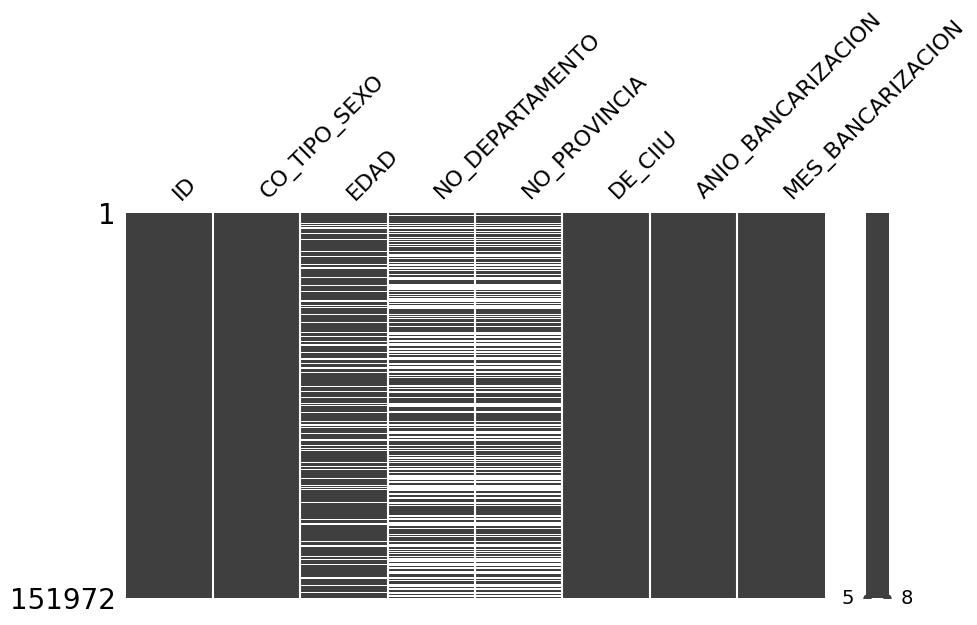

In [15]:
msno.matrix(df_customers, figsize=(10, 5))

# *JOIN*

In [16]:
df_join = df_customers.drop(columns=['NO_DEPARTAMENTO', 'NO_PROVINCIA', 'DE_CIIU']).merge(
    df_balances_unirow, how='left', on='ID'
)

In [17]:
df_join['EDAD'].describe()

count   126566.000000
mean        46.586445
std         11.830842
min         19.000000
25%         38.000000
50%         45.000000
75%         55.000000
max        107.000000
Name: EDAD, dtype: float64

/tmp/ipykernel_23468/1546855181.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_join['EDAD'], shade=True)


<Axes: xlabel='EDAD', ylabel='Density'>

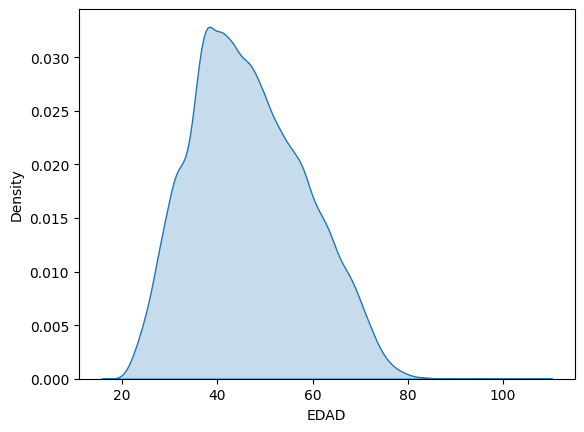

In [18]:
sns.kdeplot(df_join['EDAD'], shade=True)

/tmp/ipykernel_23468/1944178101.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_join['EDAD'], shade=True)


<Axes: xlabel='EDAD', ylabel='Density'>

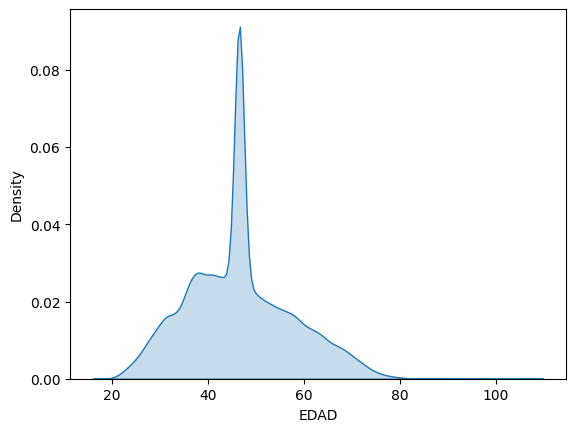

In [19]:
# # fillna EDAD with KNN
# from sklearn.impute import KNNImputer

# imputer = KNNImputer(n_neighbors=5)
# df_join['EDAD'] = imputer.fit_transform(df_join[['EDAD']])
# sns.kdeplot(df_join['EDAD'], shade=True)

In [20]:
df_join.isna().sum()

ID                                         0
CO_TIPO_SEXO                               0
EDAD                                       0
ANIO_BANCARIZACION                         0
MES_BANCARIZACION                          0
CANT_EMP_NEG_max                           0
CANT_EMP_NEG_last                          0
CANT_EMP_CONS_max                          0
CANT_EMP_CONS_last                         0
CANT_EMP_HIPOT_max                         0
CANT_EMP_HIPOT_last                        0
VAR_SALDO_EMP_TOTAL_1_mean                 0
VAR_SALDO_EMP_TOTAL_1_median               0
VAR_SALDO_EMP_TOTAL_MA3_mean               0
VAR_SALDO_EMP_TOTAL_MA3_median             0
VAR_SALDO_EMP_TOTAL_MA6_mean               0
VAR_SALDO_EMP_TOTAL_MA6_median             0
VAR_SALDO_EMP_TOTAL_MA8_mean               0
VAR_SALDO_EMP_TOTAL_MA8_median             0
VAR_SALDO_EMP_TOTAL-VENCIDO_1_mean         0
VAR_SALDO_EMP_TOTAL-VENCIDO_1_median       0
VAR_SALDO_EMP_TOTAL-VENCIDO_MA3_mean       0
VAR_SALDO_

In [21]:
nc, cc = get_cols(df_join)
df_join[nc].std(numeric_only=True).reset_index().sort_values(by=0, ascending=False)

,index,0
38,VAR_SALDO_TOTAL-VENCIDO_MA6_median,22617.757631
37,VAR_SALDO_TOTAL-VENCIDO_MA6_mean,22612.138969
21,VAR_SALDO_EMP_TOTAL-VENCIDO_MA6_mean,22233.764552
22,VAR_SALDO_EMP_TOTAL-VENCIDO_MA6_median,22233.047553
14,VAR_SALDO_EMP_TOTAL_MA6_median,22216.477058
13,VAR_SALDO_EMP_TOTAL_MA6_mean,22216.476996
35,VAR_SALDO_TOTAL-VENCIDO_MA3_mean,18322.146769
19,VAR_SALDO_EMP_TOTAL-VENCIDO_MA3_mean,17761.741784
11,VAR_SALDO_EMP_TOTAL_MA3_mean,17755.590122
36,VAR_SALDO_TOTAL-VENCIDO_MA3_median,4811.225288


In [22]:
df_join.dtypes

ID                                           object
CO_TIPO_SEXO                               category
EDAD                                        float64
ANIO_BANCARIZACION                            int64
MES_BANCARIZACION                             int64
CANT_EMP_NEG_max                              int64
CANT_EMP_NEG_last                             int64
CANT_EMP_CONS_max                             int64
CANT_EMP_CONS_last                            int64
CANT_EMP_HIPOT_max                            int64
CANT_EMP_HIPOT_last                           int64
VAR_SALDO_EMP_TOTAL_1_mean                  float64
VAR_SALDO_EMP_TOTAL_1_median                float64
VAR_SALDO_EMP_TOTAL_MA3_mean                float64
VAR_SALDO_EMP_TOTAL_MA3_median              float64
VAR_SALDO_EMP_TOTAL_MA6_mean                float64
VAR_SALDO_EMP_TOTAL_MA6_median              float64
VAR_SALDO_EMP_TOTAL_MA8_mean                float64
VAR_SALDO_EMP_TOTAL_MA8_median              float64
VAR_SALDO_EM

In [23]:
df_train = pd.read_csv('../data/raw/train.csv').merge(df_join, how='left', on='ID')
df_test = pd.read_csv('../data/raw/test.csv').merge(df_join, how='left', on='ID')

In [ ]:
display(df_train['TARGET'].value_counts(normalize=True))
display(df_test['TARGET'].value_counts(normalize=True))

In [31]:
df_train.to_parquet('../data/processed/train.gzip', compression='gzip')
df_test.to_parquet('../data/processed/test.gzip', compression='gzip')

In [24]:
df_test.isna().sum()

ID                                             0
TARGET                                     60789
CO_TIPO_SEXO                                   0
EDAD                                           0
ANIO_BANCARIZACION                             0
MES_BANCARIZACION                              0
CANT_EMP_NEG_max                               0
CANT_EMP_NEG_last                              0
CANT_EMP_CONS_max                              0
CANT_EMP_CONS_last                             0
CANT_EMP_HIPOT_max                             0
CANT_EMP_HIPOT_last                            0
VAR_SALDO_EMP_TOTAL_1_mean                     0
VAR_SALDO_EMP_TOTAL_1_median                   0
VAR_SALDO_EMP_TOTAL_MA3_mean                   0
VAR_SALDO_EMP_TOTAL_MA3_median                 0
VAR_SALDO_EMP_TOTAL_MA6_mean                   0
VAR_SALDO_EMP_TOTAL_MA6_median                 0
VAR_SALDO_EMP_TOTAL_MA8_mean                   0
VAR_SALDO_EMP_TOTAL_MA8_median                 0
VAR_SALDO_EMP_TOTAL-

In [25]:
df_train.isna().sum()

ID                                         0
TARGET                                     0
CO_TIPO_SEXO                               0
EDAD                                       0
ANIO_BANCARIZACION                         0
MES_BANCARIZACION                          0
CANT_EMP_NEG_max                           0
CANT_EMP_NEG_last                          0
CANT_EMP_CONS_max                          0
CANT_EMP_CONS_last                         0
CANT_EMP_HIPOT_max                         0
CANT_EMP_HIPOT_last                        0
VAR_SALDO_EMP_TOTAL_1_mean                 0
VAR_SALDO_EMP_TOTAL_1_median               0
VAR_SALDO_EMP_TOTAL_MA3_mean               0
VAR_SALDO_EMP_TOTAL_MA3_median             0
VAR_SALDO_EMP_TOTAL_MA6_mean               0
VAR_SALDO_EMP_TOTAL_MA6_median             0
VAR_SALDO_EMP_TOTAL_MA8_mean               0
VAR_SALDO_EMP_TOTAL_MA8_median             0
VAR_SALDO_EMP_TOTAL-VENCIDO_1_mean         0
VAR_SALDO_EMP_TOTAL-VENCIDO_1_median       0
VAR_SALDO_

In [26]:
df_train['ID'].isin(df_balances['ID']).value_counts()

ID
True    91183
Name: count, dtype: int64

In [27]:
df_test['ID'].isin(df_balances['ID']).value_counts()

ID
True    60789
Name: count, dtype: int64

In [28]:
df_train['ID'].isin(df_customers['ID']).value_counts()

ID
True    91183
Name: count, dtype: int64

In [29]:
df_test['ID'].isin(df_customers['ID']).value_counts()

ID
True    60789
Name: count, dtype: int64

In [30]:
df_train.dtypes

ID                                           object
TARGET                                        int64
CO_TIPO_SEXO                               category
EDAD                                        float64
ANIO_BANCARIZACION                            int64
MES_BANCARIZACION                             int64
CANT_EMP_NEG_max                              int64
CANT_EMP_NEG_last                             int64
CANT_EMP_CONS_max                             int64
CANT_EMP_CONS_last                            int64
CANT_EMP_HIPOT_max                            int64
CANT_EMP_HIPOT_last                           int64
VAR_SALDO_EMP_TOTAL_1_mean                  float64
VAR_SALDO_EMP_TOTAL_1_median                float64
VAR_SALDO_EMP_TOTAL_MA3_mean                float64
VAR_SALDO_EMP_TOTAL_MA3_median              float64
VAR_SALDO_EMP_TOTAL_MA6_mean                float64
VAR_SALDO_EMP_TOTAL_MA6_median              float64
VAR_SALDO_EMP_TOTAL_MA8_mean                float64
VAR_SALDO_EM